# Import Libraries

In [42]:
import pandas as pd 
from matplotlib import pyplot as plt 
import numpy as np 
import seaborn as sns 
import lightgbm as lgb 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
from choices import param_dict 
from utilities import deets

# Load data

In [44]:
x = pd.read_csv('compiled_data_v3/x_phot_minmax.csv' , index_col='name')
x_col = x.columns.to_list()
i = pd.read_csv('compiled_data_v3/id_frame.csv' , index_col='name')
df = pd.merge(i,x , left_index =True , right_index =True )
df = df[df['offset']<1.01]
feat_to_drop = np.unique(param_dict['hardness'] + param_dict['IRAC']+[
    '0p5_2csc' , '2-10 keV (XMM)' , '1_2_csc' , '0p5_8_csc'
]+['var_inter_hard_prob_hs', 'ks_intra_prob_b', 'var_inter_hard_sigma_hm', 'var_inter_hard_prob_ms', 'var_inter_hard_prob_hm',] )


classes = ['AGN' ,'STAR' ,'YSO' ,'HMXB' , 'LMXB' , 'ULX' ,'CV' , 'PULSAR']
df = df[df['class'].isin(classes)]
#from sklearn.preprocessing import LabelEncoder
#y_int = LabelEncoder().fit_transform(df['class'])
deets(df,1)
u = pd.read_csv('compiled_data_v3/x_phot_minmax-unid-var-src.csv' , index_col='name')
u = u.drop(columns=feat_to_drop)
u.columns = u.columns.str.replace(' ' ,'_' , regex=False)
x = df[x_col]
x = x.drop(columns=feat_to_drop)
x.columns = x.columns.str.replace(' ' ,'_' , regex=False)
y = df['class']
deets(x)
deets(u)

_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 73
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 41
_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 39893
Number of Columns : 41
_____________________________________________________


## Loss Function

In [26]:
from scipy.misc import derivative

In [27]:
def focal_loss_lgb(y_pred, dtrain, alpha, gamma):
	a,g = alpha, gamma
	y_true = dtrain.label
	def fl(x,t):
		p = 1/(1+np.exp(-x))
		return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
	partial_fl = lambda x: fl(x, y_true)
	grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
	hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
	return grad, hess

In [28]:
def focal_loss_lgb_eval_error(y_pred, dtrain, alpha, gamma):
	a,g = alpha, gamma
	y_true = dtrain.label
	p = 1/(1+np.exp(-y_pred))
	loss = -( a*y_true + (1-a)*(1-y_true) ) * (( 1 - ( y_true*p + (1-y_true)*(1-p)) )**g) * ( y_true*np.log(p)+(1-y_true)*np.log(1-p) )
	return 'focal_loss', np.mean(loss), False

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
y_int = LabelEncoder().fit_transform(y)

In [35]:
x_train,x_test , y_train , y_test = train_test_split(x,y_int , test_size = 0.2 , stratify=y)

focal_loss = lambda x,y: focal_loss_lgb(x, y, 0.25, 1.)
eval_error = lambda x,y: focal_loss_lgb_eval_error(x, y, 0.25, 1.)
lgbtrain = lgb.Dataset(x_train, y_train)
lgbeval = lgb.Dataset(x_test, y_test)
params  = {'learning_rate':0.1, 'num_boost_round':10}
model = lgb.train(params, lgbtrain, valid_sets=[lgbeval], fobj=focal_loss, feval=eval_error )

#model = lgb.LGBMClassifier(n_estimators=100 , objective= 'multiclass', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity = 0 , random_state=42 , num_class=len(np.unique(y)) ,force_col_wise=True)
#model.train()

[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9965
[LightGBM] [Info] Number of data points in the train set: 6162, number of used features: 41
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's focal_loss: -0.319417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	valid_0's focal_loss: -0.319417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [36]:
import numpy as np
from scipy import optimize
from scipy import special

class FocalLoss:

    def __init__(self, gamma, alpha=None):
        self.alpha = alpha
        self.gamma = gamma

    def at(self, y):
        if self.alpha is None:
            return np.ones_like(y)
        return np.where(y, self.alpha, 1 - self.alpha)

    def pt(self, y, p):
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return np.where(y, p, 1 - p)

    def __call__(self, y_true, y_pred):
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        return -at * (1 - pt) ** self.gamma * np.log(pt)

    def grad(self, y_true, y_pred):
        y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        g = self.gamma
        return at * y * (1 - pt) ** g * (g * pt * np.log(pt) + pt - 1)

    def hess(self, y_true, y_pred):
        y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        g = self.gamma

        u = at * y * (1 - pt) ** g
        du = -at * y * g * (1 - pt) ** (g - 1)
        v = g * pt * np.log(pt) + pt - 1
        dv = g * np.log(pt) + g + 1

        return (du * v + u * dv) * y * (pt * (1 - pt))

    def init_score(self, y_true):
        res = optimize.minimize_scalar(
            lambda p: self(y_true, p).sum(),
            bounds=(0, 1),
            method='bounded'
        )
        p = res.x
        log_odds = np.log(p / (1 - p))
        return log_odds

    def lgb_obj(self, preds, train_data):
        y = train_data.get_label()
        p = special.expit(preds)
        return self.grad(y, p), self.hess(y, p)

    def lgb_eval(self, preds, train_data):
        y = train_data.get_label()
        p = special.expit(preds)
        is_higher_better = False
        return 'focal_loss', self(y, p).mean(), is_higher_better

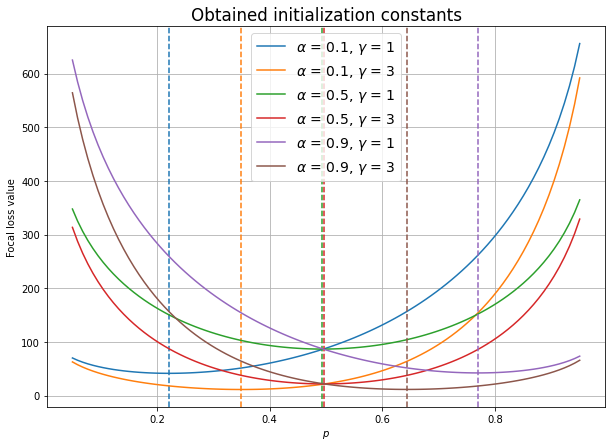

In [37]:
import matplotlib
import matplotlib.pyplot as plt
from scipy import special

fig, ax = plt.subplots(figsize=(10, 7))
matplotlib.rc('font', size=14)

np.random.seed(10)
y = np.random.randint(2, size=500)  # random 0s and 1s

for alpha in [.1, .5, .9]:
    for gamma in [1, 3]:
        fl = FocalLoss(alpha=alpha, gamma=gamma)
        ps = np.linspace(5e-2, 1 - 5e-2, 100)
        ls = [fl(y, p).sum() for p in ps]

        curve = ax.plot(ps, ls, label=r'$\alpha$ = %s, $\gamma$ = %s' % (alpha, gamma))[0]
        p = special.expit(fl.init_score(y))
        ax.axvline(p, color=curve.get_color(), linestyle='--')

ax.legend()
ax.grid()
ax.set_title('Obtained initialization constants')
ax.set_xlabel(r'$p$')
ax.set_ylabel('Focal loss value')
fig.savefig('focal_loss_min.png')

In [41]:
y

array([1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,

In [47]:
np.unique(y_int)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [50]:
import lightgbm
import numpy as np
import pandas as pd
from scipy import optimize
from scipy import special
from sklearn import metrics
from sklearn import model_selection


X = x.copy()

fl = FocalLoss(alpha=None, gamma=0)

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y_int,
    random_state=42 , test_size=0.2
)

X_fit, X_val, y_fit, y_val = model_selection.train_test_split(
    X_train, y_train,
    random_state=42
)

fit = lightgbm.Dataset(
    X_fit, y_fit,
    init_score=np.full_like(y_fit, fl.init_score(y_fit), dtype=float)
)

val = lightgbm.Dataset(
    X_val, y_val,
    init_score=np.full_like(y_val, fl.init_score(y_fit), dtype=float),
    reference=fit
)

model = lightgbm.train(
    params={'learning_rate': 0.01},
    train_set=fit,
    num_boost_round=10000,
    valid_sets=(fit, val),
    valid_names=('fit', 'val'),
    early_stopping_rounds=20,
    verbose_eval=100,
    fobj=fl.lgb_obj,
    feval=fl.lgb_eval
)

y_pred = special.expit(fl.init_score(y_fit) + model.predict(X_test))

print()
#print(f"Test's ROC AUC: {metrics.roc_auc_score(y_test, y_pred , multi_class='ovr' , average='none'):.5f}")
#print(f"Test's logloss: {metrics.log_loss(y_test, y_pred , multi_class='ovr' , average='none'):.5f}")

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9965
[LightGBM] [Info] Number of data points in the train set: 4621, number of used features: 41
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 20 rounds
[100]	fit's focal_loss: 0.3822	val's focal_loss: 0.393179
[200]	fit's focal_loss: 0.307381	val's focal_loss: 0.327342
[300]	fit's focal_loss: 0.262547	val's focal_loss: 0.288734
[400]	fit's focal_loss: 0.233831	val's focal_loss: 0.265599
[500]	fit's focal_loss: 0.211047	val's focal_loss: 0.246634
[600]	fit's focal_loss: 0.186276	val's focal_loss: 0.22818
[700]	fit's focal_loss: 0.16885	val's focal_loss: 0.214393
[800]	fit's focal_loss: 0.154037	val's focal_loss: 0.202318
[900]	fit's focal_loss: 0.140003	val's focal_loss: 0.1

In [52]:
y_pred_int = np.rint(y_pred)
np.unique(y_pred_int)

array([0., 1.])

In [53]:
import numpy as np
from joblib import Parallel, delayed
from sklearn.multiclass import _ConstantPredictor
from sklearn.preprocessing import LabelBinarizer
from scipy import special
import lightgbm as lgb


class OneVsRestLightGBMWithCustomizedLoss:

    def __init__(self, loss, n_jobs=3):
        self.loss = loss
        self.n_jobs = n_jobs

    def fit(self, X, y, **fit_params):

        self.label_binarizer_ = LabelBinarizer(sparse_output=True)
        Y = self.label_binarizer_.fit_transform(y)
        Y = Y.tocsc()
        self.classes_ = self.label_binarizer_.classes_
        columns = (col.toarray().ravel() for col in Y.T)
        if 'eval_set' in fit_params:
            # use eval_set for early stopping
            X_val, y_val = fit_params['eval_set'][0]
            Y_val = self.label_binarizer_.transform(y_val)
            Y_val = Y_val.tocsc()
            columns_val = (col.toarray().ravel() for col in Y_val.T)
            self.results_ = Parallel(n_jobs=self.n_jobs)(delayed(self._fit_binary)
                                                         (X, column, X_val, column_val, **fit_params) for
                                                         i, (column, column_val) in
                                                         enumerate(zip(columns, columns_val)))
        else:
            # eval set not available
            self.results_ = Parallel(n_jobs=self.n_jobs)(delayed(self._fit_binary)
                                                         (X, column, None, None, **fit_params) for i, column
                                                         in enumerate(columns))

        return self

    def _fit_binary(self, X, y, X_val, y_val, **fit_params):
        unique_y = np.unique(y)
        init_score_value = self.loss.init_score(y)
        if len(unique_y) == 1:
            estimator = _ConstantPredictor().fit(X, unique_y)
        else:
            fit = lgb.Dataset(X, y, init_score=np.full_like(y, init_score_value, dtype=float))
            if 'eval_set' in fit_params:
                val = lgb.Dataset(X_val, y_val, init_score=np.full_like(y_val, init_score_value, dtype=float),
                                  reference=fit)

                estimator = lgb.train(params=fit_params,
                                      train_set=fit,
                                      valid_sets=(fit, val),
                                      valid_names=('fit', 'val'),
                                      early_stopping_rounds=10,
                                      fobj=self.loss.lgb_obj,
                                      feval=self.loss.lgb_eval,
                                      verbose_eval=10)
            else:
                estimator = lgb.train(params=fit_params,
                                      train_set=fit,
                                      fobj=self.loss.lgb_obj,
                                      feval=self.loss.lgb_eval,
                                      verbose_eval=10)

        return estimator, init_score_value

    def predict(self, X):

        n_samples = X.shape[0]
        maxima = np.empty(n_samples, dtype=float)
        maxima.fill(-np.inf)
        argmaxima = np.zeros(n_samples, dtype=int)

        for i, (e, init_score) in enumerate(self.results_):
            margins = e.predict(X, raw_score=True)
            prob = special.expit(margins + init_score)
            np.maximum(maxima, prob, out=maxima)
            argmaxima[maxima == prob] = i

        return argmaxima

    def predict_proba(self, X):
        y = np.zeros((X.shape[0], len(self.results_)))
        for i, (e, init_score) in enumerate(self.results_):
            margins = e.predict(X, raw_score=True)
            y[:, i] = special.expit(margins + init_score)
        y /= np.sum(y, axis=1)[:, np.newaxis]
        return y

In [56]:

le = LabelEncoder()
X = x.copy()
y_label = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.30, random_state=42)

classes =[]
labeles=np.unique(y_label)
for v in labeles:
    classes.append('Class '+ str(v))
print(classes)

['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7']


In [59]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score , recall_score , confusion_matrix , plot_confusion_matrix
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)
pred_accuracy_score = accuracy_score(y_test, y_test_pred)
pred_recall_score = recall_score(y_test, y_test_pred, average='macro')
print('Prediction accuracy', pred_accuracy_score,' recall ', pred_recall_score)

cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=labeles)
#plot_confusion_matrix(cnf_matrix, labels=classes,normalize=True,  title='Confusion matrix')


Prediction accuracy 0.9294677628732151  recall  0.7314442123274739


In [62]:
cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=labeles , normalize='true')
cnf_matrix

array([[0.97503467, 0.        , 0.01386963, 0.        , 0.00138696,
        0.00277393, 0.00693481, 0.        ],
       [0.14285714, 0.42857143, 0.06122449, 0.        , 0.08163265,
        0.18367347, 0.04081633, 0.06122449],
       [0.03139013, 0.        , 0.91479821, 0.        , 0.        ,
        0.03139013, 0.01793722, 0.0044843 ],
       [0.02272727, 0.09090909, 0.        , 0.79545455, 0.        ,
        0.02272727, 0.04545455, 0.02272727],
       [0.06451613, 0.19354839, 0.        , 0.        , 0.25806452,
        0.16129032, 0.06451613, 0.25806452],
       [0.00468933, 0.00820633, 0.003517  , 0.        , 0.00117233,
        0.96600234, 0.        , 0.01641266],
       [0.21311475, 0.01639344, 0.16393443, 0.01639344, 0.        ,
        0.04918033, 0.54098361, 0.        ],
       [0.        , 0.        , 0.00303951, 0.        , 0.        ,
        0.02431611, 0.        , 0.97264438]])